# Imports

In [1]:
import os
import sys
import pickle
import cv2
import numpy as np
from tqdm import tqdm

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))

from SRModels.constants import *
from SRModels.loading_methods import load_predictions_dataset
from SRModels.deep_learning_models.SRCNN_model import SRCNNModel
from SRModels.deep_learning_models.EDSR_model import EDSR
from SRModels.deep_learning_models.ESRGAN_model import ESRGAN
from SRModels.defect_detection_models.VGG16_model import FineTunedVGG16

c:\Users\bgmanuel\anaconda3\envs\py310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\bgmanuel\anaconda3\envs\py310\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.

# CONSTANTS

In [2]:
SRCNN_PRETRAINED_PATH = os.path.abspath(os.path.join(os.getcwd(), "deep_learning_models/models/SRCNN/SRCNN_20250908_142345/SRCNN_20250908_142345.h5"))
SRCNN_HR_DIMENSIONS_PATH = os.path.abspath(os.path.join(os.getcwd(), "deep_learning_models/models/SRCNN/SRCNN_20250908_142345/SRCNN_20250908_142345_hrh_hrw.pkl"))
SRCNN_TRAIN_METRICS_PATH = os.path.abspath(os.path.join(os.getcwd(), "deep_learning_models/models/SRCNN/SRCNN_20250908_142345/SRCNN_20250908_142345_metrics.pkl"))

EDSR_PRETRAINED_PATH = os.path.abspath(os.path.join(os.getcwd(), "deep_learning_models/models/EDSR/EDSR_20250908_041338/EDSR_x2_20250908_041338.h5"))
EDSR_TRAIN_METRICS_PATH = os.path.abspath(os.path.join(os.getcwd(), "deep_learning_models/models/EDSR/EDSR_20250908_041338/EDSR_20250908_041338_metrics.pkl"))

ESRGAN_GENERATOR_PRETRAINED_PATH = os.path.abspath(os.path.join(os.getcwd(), "deep_learning_models/models/ESRGAN/ESRGAN_20250908_112228/ESRGAN_generator_x2_20250908_112228.h5"))
ESRGAN_DISCRIMINATOR_PRETRAINED_PATH = os.path.abspath(os.path.join(os.getcwd(), "deep_learning_models/models/ESRGAN/ESRGAN_20250908_112228/ESRGAN_discriminator_x2_20250908_112228.h5"))
ESRGAN_TRAIN_METRICS_PATH = os.path.abspath(os.path.join(os.getcwd(), "deep_learning_models/models/ESRGAN/ESRGAN_20250908_112228/ESRGAN_20250908_112228_metrics.pkl"))

VGG16_PRETRAINED_PATH = os.path.abspath(os.path.join(os.getcwd(), "defect_detection_models/models/VGG16/VGG16_20250908_115146.h5"))

# LR Dataset loading

In [3]:
# Paths to LR images and labels map generated by preprocessing_functions
LR_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../data/images_for_predictions/LR"))
CLASS_LABELS_PATH = os.path.abspath(os.path.join(os.getcwd(), "../data/images_for_predictions/predictions_class_labels_map.pkl"))

# Load arrays
X, y = load_predictions_dataset(LR_ROOT, CLASS_LABELS_PATH)
print(f"Loaded LR images: {X.shape} | Labels: {y.shape}")

Loaded LR images: (113, 239, 239, 3) | Labels: (113,)


# SRCNN model predictions

In [5]:
# Load HR dimensions
with open(SRCNN_HR_DIMENSIONS_PATH, "rb") as f:
    hr_h, hr_w = pickle.load(f)

# Load pretrained SRCNN model
pretrained_srcnn_model = SRCNNModel()

pretrained_srcnn_model.setup_model(from_pretrained=True, pretrained_path=SRCNN_PRETRAINED_PATH)

Loaded pretrained model from c:\Users\bgmanuel\InteligenciaArtificial\MasterInteligenciaArtificial\Periodo2\TFM\Super-Resolution-Images-for-3D-Printing-Defect-Detection\SRModels\deep_learning_models\models\SRCNN\SRCNN_20250908_142345\SRCNN_20250908_142345.h5


In [6]:
# Super-resolve all LR images with SRCNN (using X)
srcnn_sr_images = []
srcnn_times = []
srcnn_mean_gpus = []
srcnn_peak_gpus = []

for idx in tqdm(range(X.shape[0]), total=X.shape[0], desc="SRCNN inference"):
    sr_img, metrics = pretrained_srcnn_model.super_resolve_image(X[idx], hr_h=hr_h, hr_w=hr_w, patch_size=SRCNN_PATCH_SIZE, stride=SRCNN_STRIDE)
    srcnn_sr_images.append(sr_img)
    srcnn_times.append(metrics["time_sec"])
    srcnn_mean_gpus.append(metrics["gpu_mean_current_mb"])
    srcnn_peak_gpus.append(metrics["gpu_peak_mb"])
    
srcnn_sr_images = np.stack(srcnn_sr_images, axis=0)
srcnn_time_mean = np.mean(srcnn_times)
srcnn_gpu_mean_mean = np.mean(srcnn_mean_gpus)
srcnn_gpu_peak_max = np.max(srcnn_peak_gpus)

print(f"SRCNN: mean_time={srcnn_time_mean:.4f}s, mean_gpu={srcnn_gpu_mean_mean:.2f}MB, peak_gpu={srcnn_gpu_peak_max:.2f}MB")

SRCNN inference: 100%|██████████| 113/113 [00:12<00:00,  9.04it/s]

SRCNN: mean_time=0.0957s, mean_gpu=97.75MB, peak_gpu=288.93MB


# EDSR model predictions

In [6]:
# Load pretrained EDSR model
pretrained_edsr_model = EDSR()

pretrained_edsr_model.setup_model(scale_factor=EDSR_SCALE_FACTOR, from_pretrained=True, pretrained_path=EDSR_PRETRAINED_PATH)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Ti, compute capability 8.6
Loaded pretrained model from c:\Users\bgmanuel\InteligenciaArtificial\MasterInteligenciaArtificial\Periodo2\TFM\Super-Resolution-Images-for-3D-Printing-Defect-Detection\SRModels\deep_learning_models\models\EDSR\EDSR_20250908_041338\EDSR_x2_20250908_041338.h5
Loaded pretrained model from c:\Users\bgmanuel\InteligenciaArtificial\MasterInteligenciaArtificial\Periodo2\TFM\Super-Resolution-Images-for-3D-Printing-Defect-Detection\SRModels\deep_learning_models\models\EDSR\EDSR_20250908_041338\EDSR_x2_20250908_041338.h5


In [7]:
# Super-resolve all LR images with EDSR (using X)
edsr_sr_list = []
edsr_times = []
edsr_mean_gpus = []
edsr_peak_gpus = []

for idx, lr_img in enumerate(tqdm(X, total=X.shape[0], desc="EDSR inference")):
    sr_img, metrics = pretrained_edsr_model.super_resolve_image(lr_img, patch_size_lr=EDSR_PATCH_SIZE, stride=EDSR_STRIDE)
    edsr_sr_list.append(sr_img)
    edsr_times.append(metrics["time_sec"])
    edsr_mean_gpus.append(metrics["gpu_mean_current_mb"])
    edsr_peak_gpus.append(metrics["gpu_peak_mb"])
    
edsr_sr_images = np.stack(edsr_sr_list, axis=0)
edsr_time_mean = np.mean(edsr_times)
edsr_gpu_mean_mean = np.mean(edsr_mean_gpus)
edsr_gpu_peak_max = np.max(edsr_peak_gpus)

print(f"EDSR: mean_time={edsr_time_mean:.4f}s, mean_gpu={edsr_gpu_mean_mean:.2f}MB, peak_gpu={edsr_gpu_peak_max:.2f}MB")

EDSR inference: 100%|██████████| 113/113 [00:13<00:00,  8.21it/s]

EDSR: mean_time=0.1102s, mean_gpu=72.16MB, peak_gpu=347.40MB


# ESRGAN model predictions

In [8]:
# Load pretrained ESRGAN model
pretrained_esrgan_model = ESRGAN()

pretrained_esrgan_model.setup_model(
    from_trained=True, 
    generator_pretrained_path=ESRGAN_GENERATOR_PRETRAINED_PATH, 
    discriminator_pretrained_path=ESRGAN_DISCRIMINATOR_PRETRAINED_PATH
)

- Generator loaded from: c:\Users\bgmanuel\InteligenciaArtificial\MasterInteligenciaArtificial\Periodo2\TFM\Super-Resolution-Images-for-3D-Printing-Defect-Detection\SRModels\deep_learning_models\models\ESRGAN\ESRGAN_20250908_112228\ESRGAN_generator_x2_20250908_112228.h5
- Discriminator loaded from: c:\Users\bgmanuel\InteligenciaArtificial\MasterInteligenciaArtificial\Periodo2\TFM\Super-Resolution-Images-for-3D-Printing-Defect-Detection\SRModels\deep_learning_models\models\ESRGAN\ESRGAN_20250908_112228\ESRGAN_discriminator_x2_20250908_112228.h5
- VGG model built for perceptual loss
- Generator loaded from: c:\Users\bgmanuel\InteligenciaArtificial\MasterInteligenciaArtificial\Periodo2\TFM\Super-Resolution-Images-for-3D-Printing-Defect-Detection\SRModels\deep_learning_models\models\ESRGAN\ESRGAN_20250908_112228\ESRGAN_generator_x2_20250908_112228.h5
- Discriminator loaded from: c:\Users\bgmanuel\InteligenciaArtificial\MasterInteligenciaArtificial\Periodo2\TFM\Super-Resolution-Images-for-3

In [9]:
# Super-resolve all LR images with ESRGAN (using X)
esrgan_sr_list = []
esrgan_times = []
esrgan_mean_gpus = []
esrgan_peak_gpus = []

for idx, lr_img in enumerate(tqdm(X, total=X.shape[0], desc="ESRGAN inference")):
    sr_img, metrics = pretrained_esrgan_model.super_resolve_image(lr_img, patch_size_lr=ESRGAN_PATCH_SIZE, stride=ESRGAN_STRIDE, batch_size=8)
    esrgan_sr_list.append(sr_img)
    esrgan_times.append(metrics["time_sec"])
    esrgan_mean_gpus.append(metrics["gpu_mean_current_mb"])
    esrgan_peak_gpus.append(metrics["gpu_peak_mb"])
    
esrgan_sr_images = np.stack(esrgan_sr_list, axis=0)
esrgan_time_mean = np.mean(esrgan_times)
esrgan_gpu_mean_mean = np.mean(esrgan_mean_gpus)
esrgan_gpu_peak_max = np.max(esrgan_peak_gpus)

print(f"ESRGAN: mean_time={esrgan_time_mean:.4f}s, mean_gpu={esrgan_gpu_mean_mean:.2f}MB, peak_gpu={esrgan_gpu_peak_max:.2f}MB")

ESRGAN inference: 100%|██████████| 113/113 [02:23<00:00,  1.27s/it]

ESRGAN: mean_time=1.2475s, mean_gpu=168.40MB, peak_gpu=694.18MB


# VGG16 model predictions

In [10]:
# Load pretrained VGG16 model for feature extraction
pretrained_vgg16_model = FineTunedVGG16()

pretrained_vgg16_model.setup_model(from_pretrained=True, pretrained_path=VGG16_PRETRAINED_PATH)

Loaded pretrained model from c:\Users\bgmanuel\InteligenciaArtificial\MasterInteligenciaArtificial\Periodo2\TFM\Super-Resolution-Images-for-3D-Printing-Defect-Detection\SRModels\defect_detection_models\models\VGG16\VGG16_20250908_115146.h5
Loaded pretrained model from c:\Users\bgmanuel\InteligenciaArtificial\MasterInteligenciaArtificial\Periodo2\TFM\Super-Resolution-Images-for-3D-Printing-Defect-Detection\SRModels\defect_detection_models\models\VGG16\VGG16_20250908_115146.h5


In [11]:
# Classify LR images with VGG16 majority voting
lr_labels = []
lr_confidences = []

for idx, img in enumerate(tqdm(X, total=X.shape[0], desc="VGG16 on LR")):
    label, conf = pretrained_vgg16_model.classify_defects_method(
        image=img, patch_size=VGG_PATCH_SIZE, stride=VGG_STRIDE, batch_size=64
    )
    lr_labels.append(int(label))
    lr_confidences.append(float(conf))

print(f"LR classified: {len(lr_labels)} images")

VGG16 on LR: 100%|██████████| 113/113 [00:05<00:00, 20.26it/s]

LR classified: 113 images


In [12]:
# Classify SRCNN SR images with VGG16 majority voting
srcnn_labels = []
srcnn_confidences = []

for idx, img in enumerate(tqdm(srcnn_sr_images, total=srcnn_sr_images.shape[0], desc="VGG16 on SRCNN")):
    label, conf = pretrained_vgg16_model.classify_defects_method(
        image=img, patch_size=VGG_PATCH_SIZE, stride=VGG_STRIDE, batch_size=64
    )
    srcnn_labels.append(int(label))
    srcnn_confidences.append(float(conf))

print(f"SRCNN classified: {len(srcnn_labels)} images")

VGG16 on SRCNN: 100%|██████████| 113/113 [00:11<00:00,  9.94it/s]

SRCNN classified: 113 images


In [13]:
# Classify EDSR SR images with VGG16 majority voting
edsr_labels = []
edsr_confidences = []

for idx, img in enumerate(tqdm(edsr_sr_images, total=edsr_sr_images.shape[0], desc="VGG16 on EDSR")):
    label, conf = pretrained_vgg16_model.classify_defects_method(
        image=img, patch_size=VGG_PATCH_SIZE, stride=VGG_STRIDE, batch_size=64
    )
    edsr_labels.append(int(label))
    edsr_confidences.append(float(conf))

print(f"EDSR classified: {len(edsr_labels)} images")

VGG16 on EDSR: 100%|██████████| 113/113 [00:08<00:00, 12.56it/s]

EDSR classified: 113 images


In [14]:
# Classify ESRGAN SR images with VGG16 majority voting
esrgan_labels = []
esrgan_confidences = []

for idx, img in enumerate(tqdm(esrgan_sr_images, total=esrgan_sr_images.shape[0], desc="VGG16 on ESRGAN")):
    label, conf = pretrained_vgg16_model.classify_defects_method(
        image=img, patch_size=VGG_PATCH_SIZE, stride=VGG_STRIDE, batch_size=64
    )
    esrgan_labels.append(int(label))
    esrgan_confidences.append(float(conf))

print(f"ESRGAN classified: {len(esrgan_labels)} images")

VGG16 on ESRGAN: 100%|██████████| 113/113 [00:10<00:00, 11.01it/s]

ESRGAN classified: 113 images


In [15]:
# Load srcnn train metrics
with open(SRCNN_TRAIN_METRICS_PATH, "rb") as f:
    srcnn_train_metrics = pickle.load(f)
print(srcnn_train_metrics)

{'eval_loss': 0.007004186976701021, 'eval_psnr': 22.68589210510254, 'eval_ssim': 0.4978533089160919, 'epoch_time_sec': 59.961374647058726, 'memory': {'gpu_mean_current_mb': 620.802490234375, 'gpu_peak_mb': 1171.17138671875}}


# Deep learning metrics

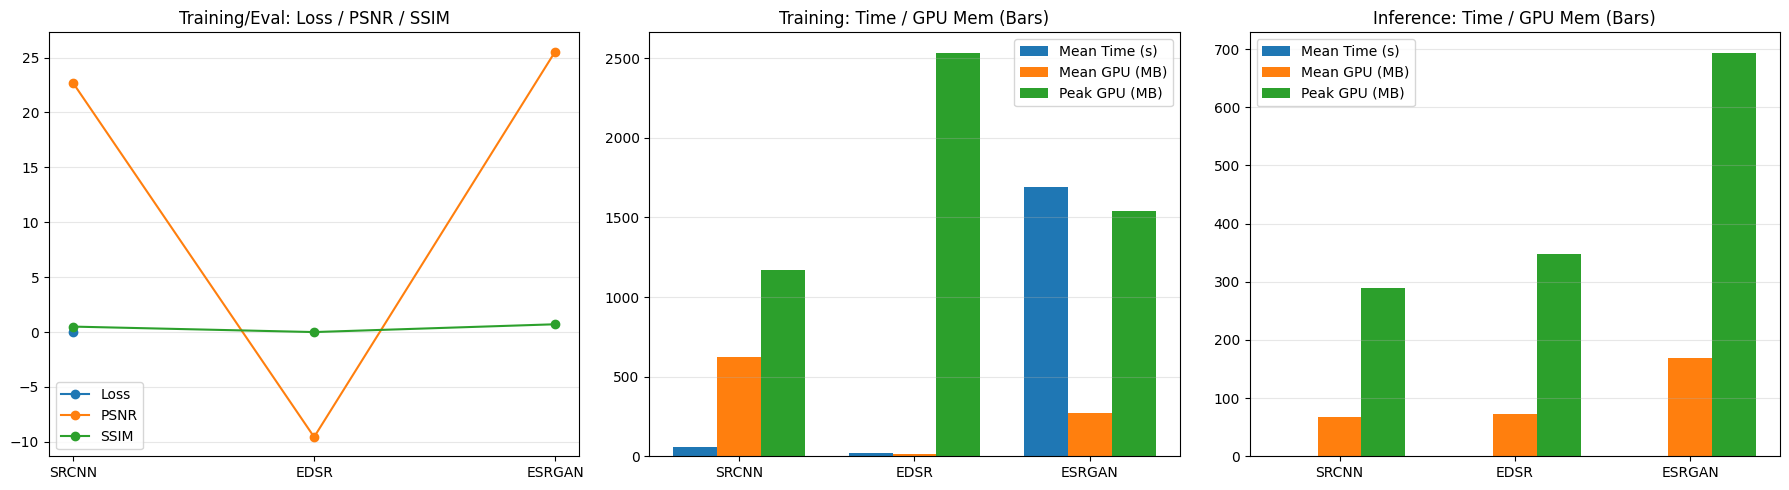

In [16]:
# Visualization 1: Training and Inference Metrics Panel
import matplotlib.pyplot as plt
import pickle
import numpy as np

# Load training metrics from pickle files if available
def load_train_metrics(path):
    try:
        with open(path, "rb") as f:
            return pickle.load(f)
    except Exception as e:
        print(f"Warning: couldn't load {path}: {e}")
        return None

# Expected structures supported (flexible):
# A) { 'loss', 'psnr', 'ssim', 'time': {'mean_epoch_time_sec'}, 'memory': {...} }
# B) { 'eval_loss', 'eval_psnr', 'eval_ssim', 'epoch_time_sec', 'memory': {...} }

srcnn_train = load_train_metrics(SRCNN_TRAIN_METRICS_PATH)
edsr_train = load_train_metrics(EDSR_TRAIN_METRICS_PATH)
esrgan_train = load_train_metrics(ESRGAN_TRAIN_METRICS_PATH)

models = ["SRCNN", "EDSR", "ESRGAN"]

# Helpers

def as_scalar(x):
    if x is None:
        return None
    if isinstance(x, (list, tuple, np.ndarray)) and len(x) > 0:
        try:
            return float(np.nanmean(x))
        except Exception:
            return None
    if isinstance(x, (int, float)):
        return float(x)
    return None


def extract_metrics(m):
    if m is None:
        return (np.nan, np.nan, np.nan, np.nan, np.nan)
    # Prefer training keys, fallback to eval_* keys
    loss_v = m.get('loss')
    if loss_v is None:
        loss_v = m.get('eval_loss')
    psnr_v = m.get('psnr')
    if psnr_v is None:
        psnr_v = m.get('eval_psnr')
    ssim_v = m.get('ssim')
    if ssim_v is None:
        ssim_v = m.get('eval_ssim')

    # Time: prefer top-level epoch_time_sec, fallback to nested time.mean_epoch_time_sec
    time_v = m.get('epoch_time_sec')
    if time_v is None:
        t = m.get('time') or {}
        time_v = t.get('mean_epoch_time_sec')

    # Memory: expect nested dict
    mem = m.get('memory') or {}
    mem_mean = mem.get('gpu_mean_current_mb')
    mem_peak = mem.get('gpu_peak_mb')

    return (
        as_scalar(loss_v),
        as_scalar(psnr_v),
        as_scalar(ssim_v),
        as_scalar(time_v),
        as_scalar(mem_mean),
    ), as_scalar(mem_peak)

train_loss = []
train_psnr = []
train_ssim = []
train_time = []
train_mean_mem = []
train_peak_mem = []

for m in [srcnn_train, edsr_train, esrgan_train]:
    vals, peak = extract_metrics(m)
    loss_v, psnr_v, ssim_v, time_v, mem_mean_v = vals
    train_loss.append(loss_v if loss_v is not None else np.nan)
    train_psnr.append(psnr_v if psnr_v is not None else np.nan)
    train_ssim.append(ssim_v if ssim_v is not None else np.nan)
    train_time.append(time_v if time_v is not None else np.nan)
    train_mean_mem.append(mem_mean_v if mem_mean_v is not None else np.nan)
    train_peak_mem.append(peak if peak is not None else np.nan)

# Convert to numeric arrays with NaNs for robustness
train_loss = np.array(train_loss, dtype=float)
train_psnr = np.array(train_psnr, dtype=float)
train_ssim = np.array(train_ssim, dtype=float)
train_time = np.array(train_time, dtype=float)
train_mean_mem = np.array(train_mean_mem, dtype=float)
train_peak_mem = np.array(train_peak_mem, dtype=float)

# Inference aggregates computed earlier in the notebook
inf_time = np.array([srcnn_time_mean, edsr_time_mean, esrgan_time_mean], dtype=float)
inf_mean_mem = np.array([srcnn_gpu_mean_mean, edsr_gpu_mean_mean, esrgan_gpu_mean_mean], dtype=float)
inf_peak_mem = np.array([srcnn_gpu_peak_max, edsr_gpu_peak_max, esrgan_gpu_peak_max], dtype=float)

x = np.arange(len(models))
width = 0.25

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Subplot 1: Training/Eval loss, PSNR, SSIM (handle missing data gracefully)
ax = axes[0]
ax.set_title("Training/Eval: Loss / PSNR / SSIM")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.grid(axis='y', alpha=0.3)
plotted_any = False
if not np.all(np.isnan(train_loss)):
    ax.plot(x, train_loss, marker='o', label='Loss')
    plotted_any = True
if not np.all(np.isnan(train_psnr)):
    ax.plot(x, train_psnr, marker='o', label='PSNR')
    plotted_any = True
if not np.all(np.isnan(train_ssim)):
    ax.plot(x, train_ssim, marker='o', label='SSIM')
    plotted_any = True
if not plotted_any:
    ax.text(0.5, 0.5, 'No training/eval metrics available', ha='center', va='center', transform=ax.transAxes)
ax.legend(loc='best')

# Subplot 2: Training mean time, mean mem, peak mem as bars
ax = axes[1]
ax.set_title("Training: Time / GPU Mem (Bars)")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.grid(axis='y', alpha=0.3)
ax.bar(x - width, np.nan_to_num(train_time, nan=0.0), width, label='Mean Time (s)')
ax.bar(x, np.nan_to_num(train_mean_mem, nan=0.0), width, label='Mean GPU (MB)')
ax.bar(x + width, np.nan_to_num(train_peak_mem, nan=0.0), width, label='Peak GPU (MB)')
ax.legend(loc='best')

# Subplot 3: Inference mean time, mean mem, peak mem as bars
ax = axes[2]
ax.set_title("Inference: Time / GPU Mem (Bars)")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.grid(axis='y', alpha=0.3)
ax.bar(x - width, inf_time, width, label='Mean Time (s)')
ax.bar(x, inf_mean_mem, width, label='Mean GPU (MB)')
ax.bar(x + width, inf_peak_mem, width, label='Peak GPU (MB)')
ax.legend(loc='best')

plt.tight_layout()
plt.show()

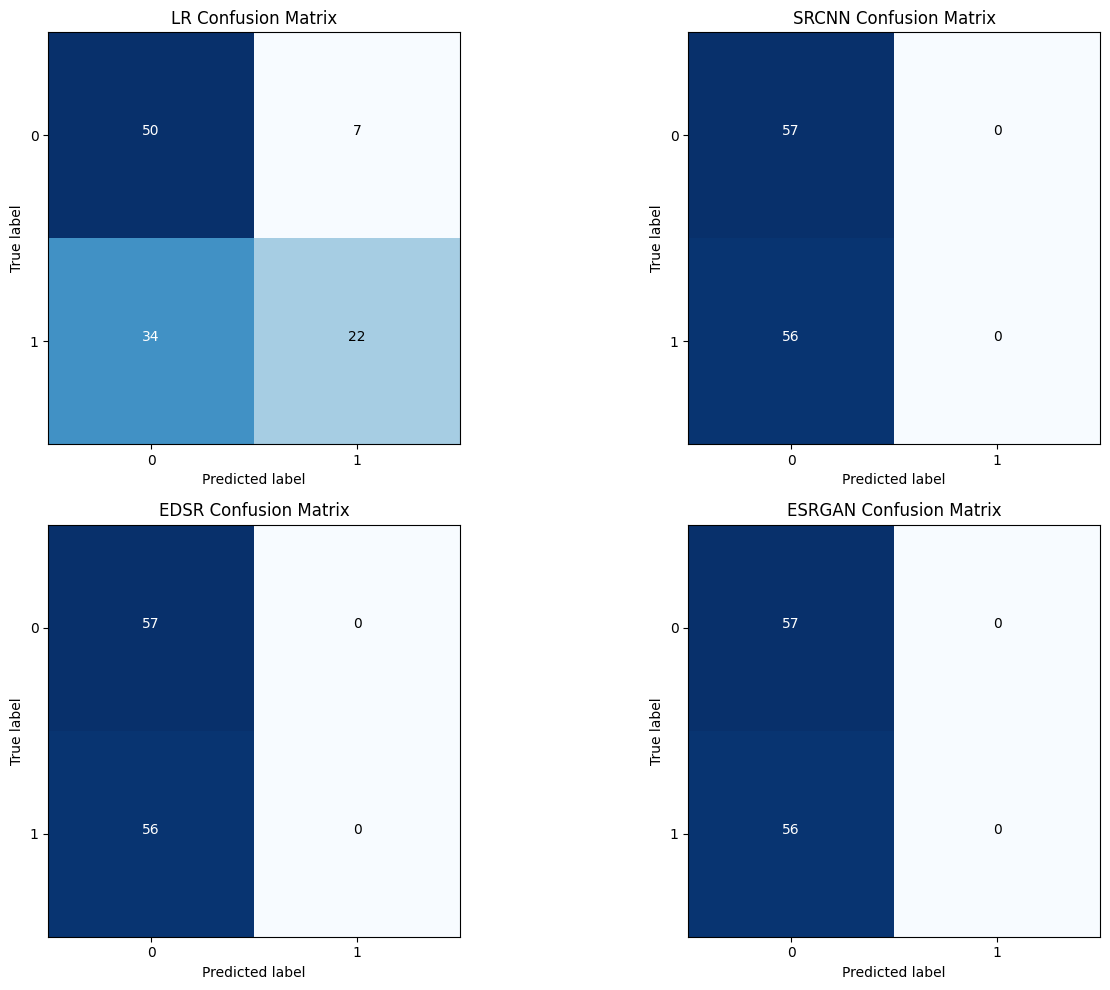

In [17]:
# Visualization 2: Confusion Matrices for VGG16 predictions
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

# Make sure true labels y exist (loaded earlier) and predictions lists exist
def plot_confusion(ax, cm, classes, title):
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    return im

class_names = [str(c) for c in sorted(np.unique(y))] if 'y' in globals() else ['0','1']

# Build confusion matrices safely
cm_lr = confusion_matrix(y, lr_labels) if 'lr_labels' in globals() else np.zeros((len(class_names), len(class_names)), dtype=int)
cm_srcnn = confusion_matrix(y, srcnn_labels) if 'srcnn_labels' in globals() else np.zeros_like(cm_lr)
cm_edsr = confusion_matrix(y, edsr_labels) if 'edsr_labels' in globals() else np.zeros_like(cm_lr)
cm_esrgan = confusion_matrix(y, esrgan_labels) if 'esrgan_labels' in globals() else np.zeros_like(cm_lr)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

plot_confusion(axes[0], cm_lr, class_names, title='LR Confusion Matrix')
plot_confusion(axes[1], cm_srcnn, class_names, title='SRCNN Confusion Matrix')
plot_confusion(axes[2], cm_edsr, class_names, title='EDSR Confusion Matrix')
plot_confusion(axes[3], cm_esrgan, class_names, title='ESRGAN Confusion Matrix')

plt.tight_layout()
plt.show()